# **Proyek Analisis Sentimen:Ulasan Aplikasi Google Lens**
- **Nama:** Hanna Safira Choirunisa
- **Email:** hannaaasc@gmail.com
- **ID Dicoding:** MC008D5X2353

## **1. Import Modul**

In [1]:
import pandas as pd  
import numpy as np
import time
import random
import os
import itertools

import matplotlib.pyplot as plt 
import seaborn as sns
import re  
import string  
import emoji

import nltk  
nltk.download('punkt')  
nltk.download('stopwords') 

from nltk.tokenize import word_tokenize  
from nltk.corpus import stopwords 
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory  
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory  
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

import tensorflow
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Input
from tensorflow.keras.layers import LSTM, Embedding, GRU
from tensorflow.keras.initializers import glorot_uniform

from imblearn.over_sampling import SMOTE, SMOTEN
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

import warnings
warnings.filterwarnings("ignore")

# Set semua seed untuk reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

random.seed(SEED)
np.random.seed(SEED)
tensorflow.random.set_seed(SEED) 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **2. Data**

In [2]:
reviews_df = pd.read_csv('Dataset scraping.csv')

In [3]:
reviews_df.head(5)

,review_id,username,rating,date,content
0,3a17e409-3930-45e5-807b-92c00c94885b,Rdani Hidayat,1,2024-12-12 21:00:03,"Makin di update makin jelek, banyak fitur bagu..."
1,f20e5384-0688-4a72-b243-2d0eb709b7b2,Trafalgar D Water Law,5,2020-12-29 17:34:13,Banyak membantu langsung mengenali apa yang ma...
2,6e0f2d38-ceb5-4ba1-a6b4-11f60468b656,HERMAWAN. PS,5,2021-11-20 07:53:02,Bisa menterjemahkan foto (langsung dari kamera...
3,51d8da31-e2f8-45a8-852f-e39fd89da951,Irlangga Marlan,2,2023-12-25 23:41:44,Update sekrang sangat tidak memuaskan. Banyak ...
4,a8d87b61-6c64-48c0-b1a3-2f40d98985d8,Agus Surya,4,2025-03-12 16:27:20,Selalu mengandalkan aplikasi google lens untuk...


## **3. Preprocessing**

### Ukuran data

In [4]:
reviews_df.shape

(13000, 5)

### Tipe data tiap kolom

In [5]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13000 entries, 0 to 12999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review_id  13000 non-null  object
 1   username   13000 non-null  object
 2   rating     13000 non-null  int64 
 3   date       13000 non-null  object
 4   content    13000 non-null  object
dtypes: int64(1), object(4)
memory usage: 507.9+ KB


Tipe data tiap kolom sudah sesuai 

### Missing value

In [6]:
reviews_df.isna().sum()

review_id    0
username     0
rating       0
date         0
content      0
dtype: int64

Tidak ada missing value

### Duplikasi data

In [7]:
reviews_df.duplicated().sum()

0

Tidak ada duplikasi data

### Cleaning text

In [8]:
def cleaningText(text):
    # Menghapus username/mentions
    text = re.sub(r'@\w+', '', text)

    # Menghapus tag
    text = re.sub(r'#\w+', '', text)

    # Menghapus teks dalam []
    text = re.sub(r'\[\w+]', '', text)

    # Menghapus karakter non-alfanumerik
    text = re.sub(r'[^\w\s]', '', text)

    # Menghapus URL
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'\b\w+(?:com|org)\b', '', text)

    # Menghapus karakter numerik
    text = re.sub(r'\d+', '', text)

    # Menyeragamkan ke lower case (case folding)
    text = text.lower()

    # Menghapus whitespace (spasi ganda, tab, newline)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip(' ')

    #  Menghapus tanda baca (seperti titik, koma, tanda seru, tanda tanya, dan titik koma)
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Menghapus emoji
    text = emoji.replace_emoji(text, replace='')
    
    return text

In [9]:
# slang words
# kamus 1
sl1 = {"@": "di", "abis": "habis", "ad": "ada", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin"}

# kamus 2
sl2 = pd.read_csv("https://raw.githubusercontent.com/haryoa/indo-collex/main/dict/inforformal-formal-Indonesian-dictionary.tsv", sep="\t")
sl2.set_index("informal", drop=True, inplace=True)
sl2 = sl2.to_dict()["formal"]
sl2

# kamus 3
sl3 = pd.read_csv("https://raw.githubusercontent.com/ramaprakoso/analisis-sentimen/master/kamus/kbba.txt", sep="\t", header=None)
sl3.set_index(0, drop=True, inplace=True)
sl3 = sl3.to_dict()[1]

# Gabungkan semua kamus slang words
sl_words = {**sl1, **sl2, **sl3}

In [10]:
# stopwords
# kamus 1: sastrawi
factory = StopWordRemoverFactory()
sw_id1 = factory.get_stop_words()

# kamus 2
sw_id2 = pd.read_csv("https://raw.githubusercontent.com/yasirutomo/python-sentianalysis-id/master/data/feature_list/stopwordsID.txt",header=None)
sw_id2 = list(sw_id1[0])

# kamus 3
sw_id3 = ['kalau', 'terus','iya','yaa','gak','nya','na','sih','ku','di','ga','ya','gaa','loh','kah','woi','woii','woy'],

# kamus 4: NLTK
sw_id4 = set(stopwords.words('indonesian'))

# Gabungkan
sw_id = sw_id1 + sw_id2 + list(sw_id3) + list(sw_id4)

In [11]:
# Flatten stopwords list
flat_sw_id = list(itertools.chain.from_iterable(
    [x if isinstance(x, list) else [x] for x in sw_id]
))

# Convert all to lowercase strings and remove any non-string elements
flat_sw_id = [str(word).lower() for word in flat_sw_id if isinstance(word, (str, int, float))]
flat_sw_id = list(set(flat_sw_id))  # Remove duplicates

In [12]:
def tokenizingText(text): # Tokenizing or splitting a string, text into a list of tokens
    text = word_tokenize(text)
    return text

def filteringText(text): # Remove stopwors in a text
    filtered = []
    for txt in text:
        if txt not in flat_sw_id:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text): # Reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def toSentence(list_words): # Convert list of words into sentence
    sentence = ' '.join(word for word in list_words)
    return sentence

def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in sl_words:
            fixed_words.append(sl_words[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [13]:
clean_df = reviews_df.copy()

# Membersihkan teks
clean_df['clean_content'] = clean_df.content.apply(cleaningText)

# Mengganti kata-kata slang dengan kata-kata standar 
clean_df.clean_content = clean_df.clean_content.apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata)
clean_df.clean_content = clean_df.clean_content.apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum)
clean_df.clean_content = clean_df.clean_content.apply(filteringText)

# Menggabungkan token-token menjadi kalimat 
clean_df.clean_content = clean_df.clean_content.apply(toSentence)

In [14]:
# data sebelum dan sesudah cleaning
display(reviews_df.head(3), clean_df.head(3))

,review_id,username,rating,date,content
0,3a17e409-3930-45e5-807b-92c00c94885b,Rdani Hidayat,1,2024-12-12 21:00:03,"Makin di update makin jelek, banyak fitur bagu..."
1,f20e5384-0688-4a72-b243-2d0eb709b7b2,Trafalgar D Water Law,5,2020-12-29 17:34:13,Banyak membantu langsung mengenali apa yang ma...
2,6e0f2d38-ceb5-4ba1-a6b4-11f60468b656,HERMAWAN. PS,5,2021-11-20 07:53:02,Bisa menterjemahkan foto (langsung dari kamera...


,review_id,username,rating,date,content,clean_content
0,3a17e409-3930-45e5-807b-92c00c94885b,Rdani Hidayat,1,2024-12-12 21:00:03,"Makin di update makin jelek, banyak fitur bagu...",update jelek fitur bagus dihilangkan salin tex...
1,f20e5384-0688-4a72-b243-2d0eb709b7b2,Trafalgar D Water Law,5,2020-12-29 17:34:13,Banyak membantu langsung mengenali apa yang ma...,membantu langsung mengenali dicari tinggal jep...
2,6e0f2d38-ceb5-4ba1-a6b4-11f60468b656,HERMAWAN. PS,5,2021-11-20 07:53:02,Bisa menterjemahkan foto (langsung dari kamera...,menterjemahkan foto langsung kamera gambar gal...


### Pelabelan

In [15]:
def text_based_label(row):
    text = row['clean_content']
    text = [word for word in text.split()]

    # Daftar kata kunci 
    positive_keywords = ['bagus', 'cepat', 'rekomen', 'puas', 'top', 'mantap', 'mantep', 'keren', 'sukses',
                       'seru', 'senang', 'menarik', 'mudah', 'memudahkan', 'gampang', 'best', 'good', 'cakep',                    
                       'suka', 'hebat', 'baik', 'cantik', 'indah', 'murah', 'efisien', 'jernih', 'mempermudah',
                       'santai', 'membantu', 'berguna', 'bermanfaat', 'memuaskan', 'sempurna', 'melatih',
                       'cepat', 'akurat', 'jelas', 'praktis', 'lumayan', 'tepat', 'stabil', 'detail', 'perfect',
                       'cocok', 'paham', 'menyenangkan', 'memahami', 'terbantu', 'belajar', 'amazing', 'berfaedah',
                       'memudahkan', 'belajar', 'baik', 'oke', 'simpel', 'simple', 'berkembang', 'berhasil', 'penting',
                       'mangtap', 'matap', 'recommended', 'luar biasa', 'istimewa', 'mantul', 'ok']
    
    negative_keywords = ['bug', 'lag', 'error', 'eror', 'lambat', 'jelek', 'berat', 'ngeselin', 'lemot',
                       'kecewa', 'crash', 'galat', 'bosan', 'mahal', 'iklan', 'payah', 'gagal', 'beda', 'salah',
                       'susah', 'sulit', 'sedih', 'buruk', 'aneh', 'nyesel', 'menyesal', 'rusak', 'jauh',
                       'gangguan', 'bingung', 'membingungkan', 'ribet', 'repot', 'sesat', 'kacau', 'bete', 'hapus',
                       'menyusahkan', 'menyulitkan', 'ganggu', 'terganggu', 'kurang', 'mogok', 'parah', 'marah',
                       'mengecewakan', 'menyebalkan', 'mengganggu', 'macet', 'lemot', 'frustasi', 'ngelag', 'ngebug',
                       'ngaco', 'ngehang', 'ngeheng', 'hilang', 'dihilangkan', 'masalah', 'jangan', 'bugnya',
                       'tanggung jawab', 'tanggungjawab', 'kembalikan', 'rusak', 'belum', 'sampah', 'burik']
    
    neutral_keywords = ['biasa', 'standar', 'cukup', 'saran', 'masukan', 'perlu', 'diperbaiki', 'perbaikan', 'harap', 'berharap',
                       'tolong', 'rata-rata', 'standar', 'saja', 'normal', 'wajar', 'tingkatkan', 'peningkatan']

    # Hitung kemunculan kata kunci
    pos_count = sum(1 for word in positive_keywords if word in text)
    neg_count = sum(1 for word in negative_keywords if word in text)
    neu_count = sum(1 for word in neutral_keywords if word in text)

    # Rule 1: Jika ada kata positif dan negatif seimbang → netral
    if pos_count > 0 and neg_count > 0 and abs(pos_count - neg_count) == 0:
        return 'neutral'
    
    # Rule 2: Dominasi kata positif
    elif pos_count > neg_count and pos_count > neu_count:
        return 'positive'
    
    # Rule 3: Dominasi kata negatif
    elif neg_count > pos_count and neg_count > neu_count:
        return 'negative'
    
    # Rule 4: Dominasi kata netral
    elif neu_count > max(pos_count, neg_count):
        return 'neutral'
    
    # Jika tidak ada kata kunci yang terdeteksi
    else:
        return 'positive'

In [16]:
# Menerapkan fungsi ke dataframe
clean_df['sentiment'] = clean_df.apply(text_based_label, axis=1)

In [17]:
# Menampilkan distribusi sentimen
clean_df.sentiment.value_counts()

sentiment
positive    12454
negative      314
neutral       232
Name: count, dtype: int64

In [18]:
print("\nContoh Ulasan dengan Label:")
for i, row in clean_df.sample(3).iterrows():
    print(f"\nRating: {row['rating']}")
    print(f"Ulasan: {row['content']}")
    print(f"Sentimen: {row['sentiment']}")


Contoh Ulasan dengan Label:

Rating: 5
Ulasan: Menunggu upgrade fitur yang lebih baik dari sekarang
Sentimen: positive

Rating: 5
Ulasan: Memberi gambaran sesuatu lebih mudah dan cepat...
Sentimen: positive

Rating: 5
Ulasan: Sangat membantu saya dalam memotret semua hal di sekitar saya di Papua
Sentimen: positive


## **4. Exploratory Data Analysis**

### Distribusi sentimen

Text(0.5, 1.0, 'Distribusi Sentimen')

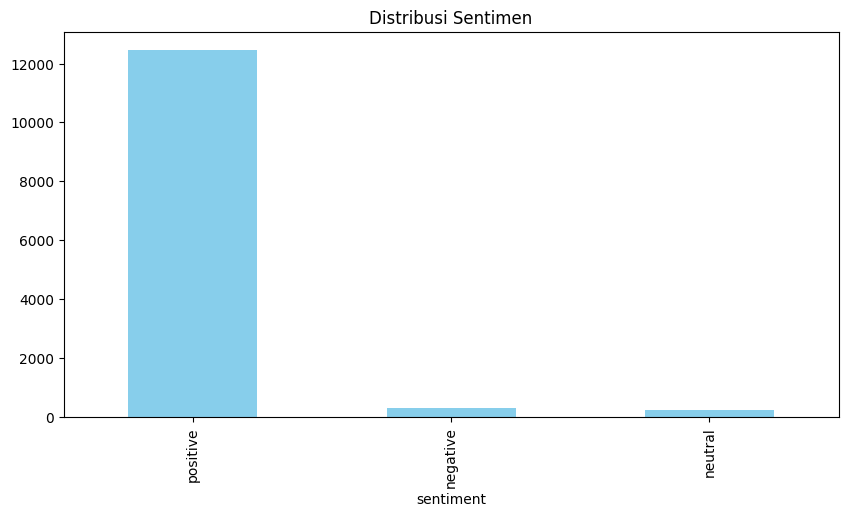

In [19]:
clean_df.sentiment.value_counts().sort_values(ascending=False).plot(kind='bar', figsize=(10, 5), color='skyblue')
plt.title('Distribusi Sentimen')

Aplikasi Google Lens memiliki banyak ulasan dengan sentimen positif dan hanya sedikit ulasan dengan sentimen negatif maupun netral.

### Distribusi rating

Text(0.5, 1.0, 'Distribusi Rating')

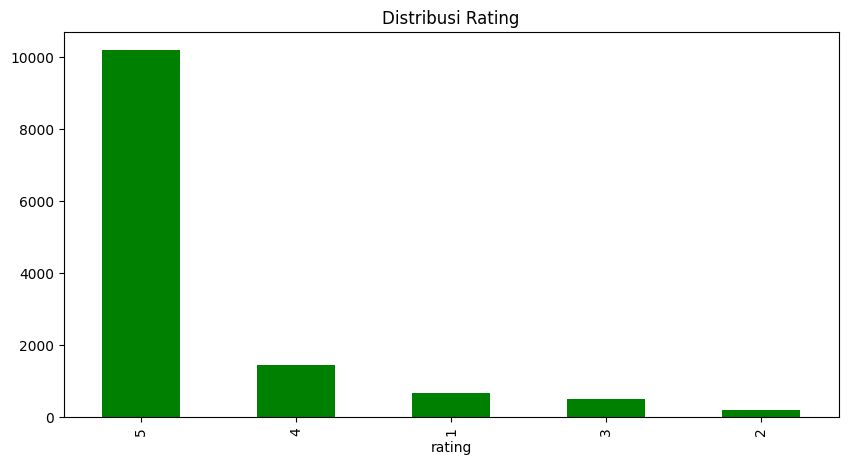

In [20]:
clean_df.rating.value_counts().sort_values(ascending=False).plot(kind='bar', figsize=(10, 5), color='green')
plt.title('Distribusi Rating')

Mayoritas pengguna memberikan rating atau bintang 5 ke aplikasi Google Lens.

### Wordcloud + Frekuensi

In [21]:
def plot_wordcloud_and_frequency(df, text_column, label_column, stopwords=None, num_word=10):
    if stopwords is None:
        stopwords = set()
    else:
        # Ensure stopwords is a set of strings
        stopwords = set(str(word).lower() for word in stopwords)
    
    labels = df[label_column].unique()
    num_cols = 2

    for label in labels:
        fig, axes = plt.subplots(1, num_cols, figsize=(12, 6))

        # Filter text by label
        text = " ".join(df[df[label_column] == label][text_column])

        # Generate wordcloud
        wordcloud = WordCloud(width=400, height=400,
                            background_color='white',
                            stopwords=stopwords,
                            min_font_size=10,
                            colormap='viridis').generate(text)

        # Display wordcloud
        axes[0].imshow(wordcloud)
        axes[0].axis("off")
        axes[0].set_title(f'WordCloud - {label}')

        # Compute word frequency (excluding stopwords)
        text_data = df[df[label_column] == label][text_column]
        words = text_data.str.split(expand=True).stack()
        words = words[~words.str.lower().isin(stopwords)]  # Filter out stopwords
        freq = words.value_counts().head(num_word)

        # Display word frequency bar plot
        if not freq.empty:
            sns.barplot(x=freq.values, y=freq.index, ax=axes[1], palette="muted")
            axes[1].set_title(f'Top {num_word} Words - {label}')
            axes[1].set_xlabel('Count')
            for p in axes[1].patches:
                axes[1].annotate(f"{p.get_width():.0f}", 
                                (p.get_x() + p.get_width(), p.get_y() + 0.5), 
                                ha='left', va='center')
        else:
            axes[1].text(0.5, 0.5, 'No words to display', 
                        ha='center', va='center')
            axes[1].axis('off')

        plt.tight_layout()
        plt.show()

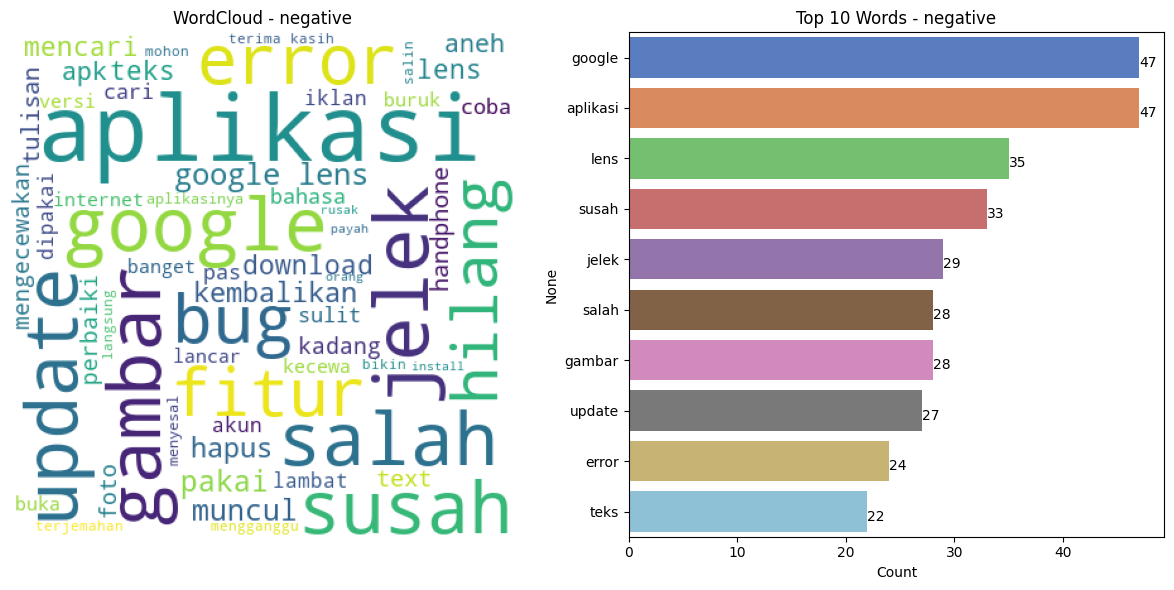

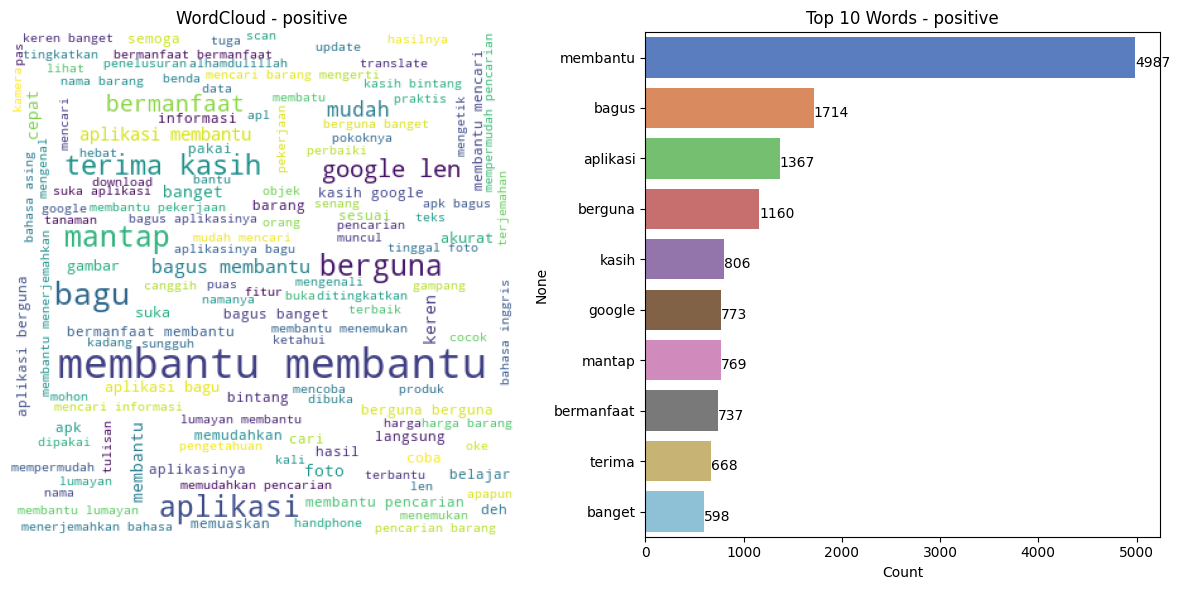

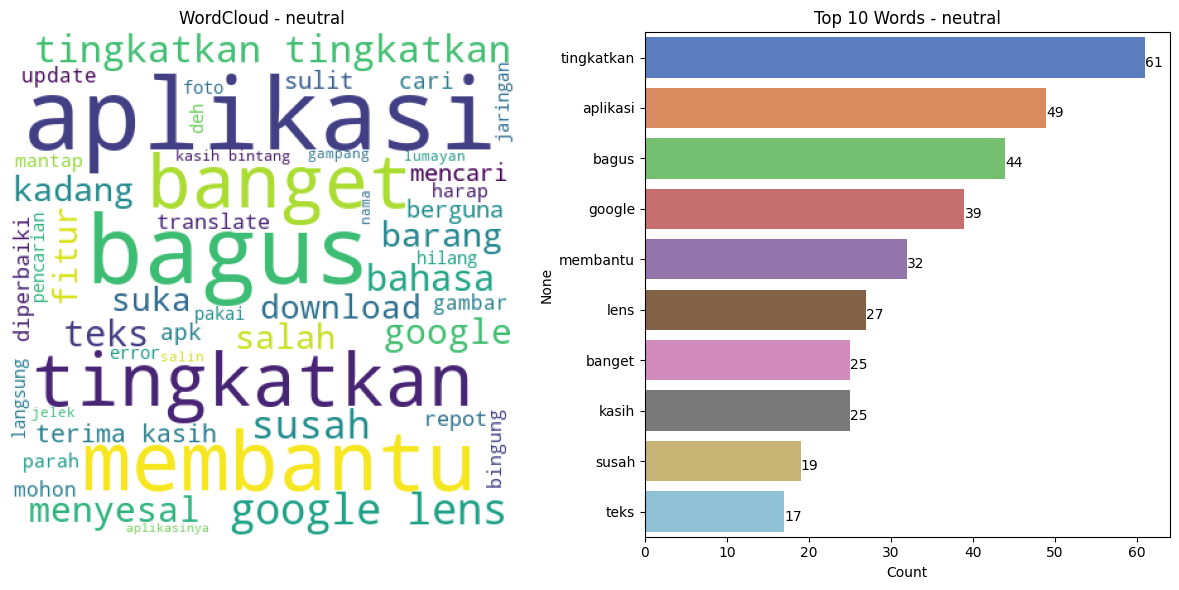

In [22]:
plot_wordcloud_and_frequency(clean_df, 'clean_content', 'sentiment', flat_sw_id, 10)

Dari WordCloud di atas, maka dapat disimpulkan bahwa:
- Pengguna memberikan ulasan positif karena aplikasi dinilai berguna, mudah digunakan, dan memiliki fitur yang membantu (seperti pemindaian teks/gambar dan terjemahan yang akurat), serta memberikan pengalaman yang memuaskan secara keseluruhan (contoh: "bagus", "mantap", "bermanfaat").

- Pengguna memberikan ulasan negatif karena mengalami masalah teknis (seperti error, bug, atau kinerja lambat), ketidakakuratan fitur (misalnya OCR atau terjemahan yang salah), serta kekecewaan terhadap pengalaman penggunaan (contoh: "kecewa", "jelek", "susah").

- Pengguna memberikan ulasan netral karena aplikasi berfungsi sesuai ekspektasi dasar tanpa keunggulan atau kekurangan yang mencolok, atau memberikan pengalaman yang kadang baik namun kadang kurang konsisten. Ulasan netral juga sering berisi saran atau permintaan peningkatan tanpa sentimen kuat (contoh: "tingkatkan").

## **5. Modeling**

### Pisahkan kolom fitur dan target

In [23]:
# Pisahkan data menjadi fitur (ulasan) dan sentimen
X = clean_df['clean_content']
y = pd.get_dummies(clean_df['sentiment']).values 

In [25]:
# Fungsi untuk evaluasi model
def evaluate_deep_model(model, X_train, X_test, y_train, y_test, epochs=50, batch_size=32, patience=5):
    # Callback
    early_stop = EarlyStopping(
        monitor='val_accuracy',
        patience=patience,
        restore_best_weights=True,
        min_delta=0.001
    )    

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1
    )
    
    # Evaluasi
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Convert predictions from probabilities to class indices
    y_pred_train_classes = np.argmax(y_pred_train, axis=1)
    y_pred_test_classes = np.argmax(y_pred_test, axis=1)
    
    # Convert true labels from one-hot to class indices
    y_train_classes = np.argmax(y_train, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    
    print("\nTraining Accuracy:", accuracy_score(y_train_classes, y_pred_train_classes))
    print("Testing Accuracy:", accuracy_score(y_test_classes, y_pred_test_classes))
    print("\nClassification Report:")
    print(classification_report(y_test_classes, y_pred_test_classes, target_names=clean_df.sentiment.unique()))
    
    return model, history

### Percobaan 1
Ekstraksi fitur: Word Embedding (Word2Vec) <br>
Pembagian data: 80/20 <br>
Model: Long Short - Term Memory (LSTM)

#### Word2Vec

In [26]:
tokenized_data = [word_tokenize(sentence.lower()) for sentence in X]

In [27]:
# Latih Word2Vec
model = Word2Vec(
    sentences=tokenized_data, 
    vector_size=128, 
    window=5, 
    min_count=1, 
    workers=1,  
    seed=SEED
)

In [28]:
# Konversi teks ke indeks berdasarkan Word2Vec vocabulary
word2idx = {word: idx for idx, word in enumerate(model.wv.index_to_key)}
sequences = [[word2idx[word] for word in sent if word in word2idx] for sent in tokenized_data]

# Padding sequences
max_len = 100
X1 = pad_sequences(sequences, maxlen=max_len)

In [29]:
# Buat embedding matrix
vocab_size = len(model.wv.index_to_key)
embedding_dim = 128  # Sesuai dengan vector_size Word2Vec

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for idx, word in enumerate(model.wv.index_to_key):
    embedding_matrix[idx] = model.wv[word]

#### Data splitting

In [30]:
# Split data 80/20
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y, test_size=0.2, random_state=42, stratify=y)

In [31]:
# Handle class imbalance dengan SMOTEN
smoten = SMOTEN(random_state=42)

# reshape
X_train1_flat = X_train1.reshape(X_train1.shape[0], -1)  
X_train1_res, y_train1_res = smoten.fit_resample(X_train1_flat, y_train1)
X_train1_res = X_train1_res.reshape(-1, max_len)

#### Model LSTM

In [32]:
# bangun model LSTM
lstm_model = Sequential([
    # Gunakan embedding matrix dari Word2Vec
    Input(shape=(max_len,)),  # Layer input
    Embedding(input_dim=vocab_size, 
              output_dim=embedding_dim, 
              weights=[embedding_matrix], 
              input_length=max_len,
              embeddings_initializer=glorot_uniform(seed=SEED), 
              trainable=True),  
    LSTM(128, return_sequences=True,
         kernel_initializer=glorot_uniform(seed=SEED),
         recurrent_initializer=glorot_uniform(seed=SEED),
         seed=SEED),
    Dropout(0.3, seed=SEED),
    LSTM(64, kernel_initializer=glorot_uniform(seed=SEED),
         recurrent_initializer=glorot_uniform(seed=SEED),
         seed=SEED),
    Dense(64, activation='relu', kernel_initializer=glorot_uniform(seed=SEED)),
    Dropout(0.3, seed=SEED),
    Dense(3, activation='softmax', kernel_initializer=glorot_uniform(seed=SEED))
])

lstm_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │       845,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,031,171 (3.93 MB)

 Trainable params: 1,031,171 (3.93 MB)

 Non-trainable params: 0 (0.00 B)

#### Evaluasi model LSTM

In [33]:
# Latih model
lstm_model, lstm_history = evaluate_deep_model(lstm_model, X_train1_res, X_test1, y_train1_res, y_test1, epochs=5, patience=2)

Epoch 1/5
935/935 ━━━━━━━━━━━━━━━━━━━━ 61s 62ms/step - accuracy: 0.7865 - loss: 0.4540 - val_accuracy: 0.9638 - val_loss: 0.1416
Epoch 2/5
935/935 ━━━━━━━━━━━━━━━━━━━━ 62s 66ms/step - accuracy: 0.9898 - loss: 0.0393 - val_accuracy: 0.9681 - val_loss: 0.1280
Epoch 3/5
935/935 ━━━━━━━━━━━━━━━━━━━━ 64s 68ms/step - accuracy: 0.9964 - loss: 0.0148 - val_accuracy: 0.9685 - val_loss: 0.1146
Epoch 4/5
935/935 ━━━━━━━━━━━━━━━━━━━━ 65s 70ms/step - accuracy: 0.9956 - loss: 0.0159 - val_accuracy: 0.9704 - val_loss: 0.1991
Epoch 5/5
935/935 ━━━━━━━━━━━━━━━━━━━━ 68s 73ms/step - accuracy: 0.9971 - loss: 0.0120 - val_accuracy: 0.9677 - val_loss: 0.1560
935/935 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step

Training Accuracy: 0.9985948007628225
Testing Accuracy: 0.9703846153846154

Classification Report:
              precision    recall  f1-score   support

    negative       0.77      0.43      0.55        63
    positive       0.38      0.35      0.36        46
     neut

Meskipun akurasi yang didapatkan besar (97%) namun model LSTM hanya dapat memprediksi benar sebagian kecil kelas negative dan positive. 

### Percobaan 2
Ekstraksi fitur: Word Embedding (Word2Vec) <br>
Pembagian data: 90/10 <br>
Model: Gate Recurrent Unit (GRU)

#### Data splitting

In [34]:
# Split data 90/10
X_train2, X_test2, y_train2, y_test2 = train_test_split(X1, y, test_size=0.1, random_state=42, stratify=y)

In [35]:
# Handle class imbalance dengan SMOTE
smoten = SMOTEN(random_state=42)

# reshape
X_train2_flat = X_train2.reshape(X_train2.shape[0], -1)  
X_train2_res, y_train2_res = smoten.fit_resample(X_train2_flat, y_train2)
X_train2_res = X_train2_res.reshape(-1, max_len)

#### Model GRU

In [36]:
# Bangun model GRU
gru_model = Sequential([
    # Gunakan embedding matrix dari Word2Vec
    Input(shape=(max_len,)),  # Layer input
    Embedding(input_dim=vocab_size, 
              output_dim=embedding_dim, 
              weights=[embedding_matrix], 
              input_length=max_len,
              embeddings_initializer=glorot_uniform(seed=SEED), 
              trainable=True),      
    GRU(128, return_sequences=True,
        kernel_initializer=glorot_uniform(seed=SEED),
        recurrent_initializer=glorot_uniform(seed=SEED),
        seed=SEED),
    Dropout(0.5, seed=SEED),
    GRU(64, kernel_initializer=glorot_uniform(seed=SEED),
        recurrent_initializer=glorot_uniform(seed=SEED),
        seed=SEED),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

gru_model.compile(optimizer= Adam(learning_rate=0.001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

gru_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 128)       │       845,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 100, 128)       │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 986,499 (3.76 MB)

 Trainable params: 986,499 (3.76 MB)

 Non-trainable params: 0 (0.00 B)

#### Evaluasi model GRU

In [37]:
# Latih model
gru_model, gru_history = evaluate_deep_model(gru_model, X_train2_res, X_test2, y_train2_res, y_test2, epochs=5, patience=2)

Epoch 1/5
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 89s 83ms/step - accuracy: 0.8152 - loss: 0.3949 - val_accuracy: 0.9677 - val_loss: 0.1086
Epoch 2/5
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 80s 76ms/step - accuracy: 0.9921 - loss: 0.0290 - val_accuracy: 0.9638 - val_loss: 0.1530
Epoch 3/5
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 82s 78ms/step - accuracy: 0.9966 - loss: 0.0127 - val_accuracy: 0.9677 - val_loss: 0.1614
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

Training Accuracy: 0.9934873762155411
Testing Accuracy: 0.9676923076923077

Classification Report:
              precision    recall  f1-score   support

    negative       0.59      0.75      0.66        32
    positive       0.42      0.48      0.45        23
     neutral       0.99      0.98      0.99      1245

    accuracy                           0.97      1300
   macro avg       0.67      0.74      0.70      1300
weighted avg       0.97      0.97      0.97      1300



Meskipun akurasi yang didapatkan besar (96.8%) namun model GRU hanya dapat memprediksi benar sebagian kecil kelas negative dan positive. 

### Percobaan 3
Ekstraksi fitur: TF-IDF <br>
Pembagian data: 80/20 <br>
Model: Multi Layer Perceptron (MLP)

#### TF-IDF

In [38]:
# Ekstraksi fitur dengan TF-IDF
tfidf = TfidfVectorizer(max_features=150)
X3 = tfidf.fit_transform(X)

#### Data splitting

In [39]:
# Split data 80/20
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y, test_size=0.2, random_state=42, stratify=y)

In [40]:
# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train3_res, y_train3_res = smote.fit_resample(X_train3, y_train3)

#### Model MLP

In [41]:
mlp_model = Sequential([
    Dense(1024, activation='relu', input_shape=(X_train3.shape[1],), 
          kernel_initializer=glorot_uniform(seed=SEED),
          trainable=True), 
    Dropout(0.5, seed=SEED),
    BatchNormalization(),

    Dense(512, activation='relu', kernel_regularizer=l2(0.01),
          kernel_initializer=glorot_uniform(seed=SEED)),
    BatchNormalization(),
    
    Dense(256, activation='relu', kernel_regularizer=l2(0.01),
          kernel_initializer=glorot_uniform(seed=SEED)),
    Dropout(0.5, seed=SEED),  
    BatchNormalization(),
    
    Dense(3, activation='softmax', kernel_initializer=glorot_uniform(seed=SEED))
])

mlp_model.compile(
    optimizer= Adam(learning_rate=0.001), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

mlp_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 1024)           │       154,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 818,691 (3.12 MB)

 Trainable params: 815,107 (3.11 MB)

 Non-trainable params: 3,584 (14.00 KB)

#### Evaluasi model MLP

In [42]:
# Latih model
mlp_model, mlp_history = evaluate_deep_model(mlp_model, X_train3, X_test3, y_train3, y_test3, epochs=20, patience=3)

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6775 - loss: 7.3564 - val_accuracy: 0.9581 - val_loss: 1.2785
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9566 - loss: 0.9229 - val_accuracy: 0.9658 - val_loss: 0.4627
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9602 - loss: 0.4235 - val_accuracy: 0.9654 - val_loss: 0.3364
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9590 - loss: 0.3651 - val_accuracy: 0.9658 - val_loss: 0.3472
Epoch 5/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9617 - loss: 0.3512 - val_accuracy: 0.9669 - val_loss: 0.3552
Epoch 6/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9599 - loss: 0.3504 - val_accuracy: 0.9654 - val_loss: 0.3166
Epoch 7/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9598 - loss: 0.3229 - val_accuracy: 0.9685 - val_loss: 0.2895
Epoch 8/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9633 - loss: 0.2905 - val_accuracy: 0.

Meskipun akurasi yang didapatkan besar (96.8%) namun model MLP hanya dapat memprediksi benar sebagian kecil kelas negative dan positive. 

### Rangkuman evaluasi model deep learning

In [43]:
# Membuat dataframe untuk menyimpan hasil evaluasi model
results = pd.DataFrame({
    'Model': ['LSTM (Word2Vec, 80/20)', 'GRU (Word2Vec, 90/10)', 'MLP (TF-IDF, 80/20)'],
    'Train Accuracy': [
        accuracy_score(np.argmax(y_train1, axis=1), np.argmax(lstm_model.predict(X_train1), axis=1)),
        accuracy_score(np.argmax(y_train2, axis=1), np.argmax(gru_model.predict(X_train2), axis=1)),
        accuracy_score(np.argmax(y_train3, axis=1), np.argmax(mlp_model.predict(X_train3), axis=1))
    ],
    'Test Accuracy': [
        accuracy_score(np.argmax(y_test1, axis=1), np.argmax(lstm_model.predict(X_test1), axis=1)),
        accuracy_score(np.argmax(y_test2, axis=1), np.argmax(gru_model.predict(X_test2), axis=1)),
        accuracy_score(np.argmax(y_test3, axis=1), np.argmax(mlp_model.predict(X_test3), axis=1))
    ]
})

325/325 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [44]:
results.sort_values(by='Test Accuracy', ascending=False, inplace=True)
results.reset_index(drop=True, inplace=True)
results

,Model,Train Accuracy,Test Accuracy
0,"LSTM (Word2Vec, 80/20)",0.995962,0.970385
1,"MLP (TF-IDF, 80/20)",0.967885,0.968462
2,"GRU (Word2Vec, 90/10)",0.988205,0.967692


## **6. Inferensi**

In [45]:
def predict_sentiment(model, text, vectorizer=None, is_rnn=True):
    # Preprocessing teks baru
    cleaned_text = cleaningText(text)
    cleaned_text = fix_slangwords(cleaned_text)
    tokenized_text = tokenizingText(cleaned_text)
    filtered_text = filteringText(tokenized_text)
    processed_text = toSentence(filtered_text)
    
    # Transformasi teks berdasarkan jenis model
    if is_rnn:
        # Untuk model LSTM/BiLSTM (Word2Vec)
        tokenized = [word_tokenize(processed_text.lower())]
        sequence = [[word2idx[word] for word in sent if word in word2idx] for sent in tokenized]
        padded_sequence = pad_sequences(sequence, maxlen=max_len)
        prediction = model.predict(padded_sequence)
    else:
        # Untuk model MLP (TF-IDF)
        vectorized_text = vectorizer.transform([processed_text])
        prediction = model.predict(vectorized_text.toarray())
    
    # Ambil kelas dengan probabilitas tertinggi
    sentiment_classes = ['negative', 'neutral', 'positive']
    predicted_class = sentiment_classes[np.argmax(prediction)]
    confidence = np.max(prediction)
    
    return predicted_class, confidence

### Contoh ulasan

In [46]:
# Contoh ulasan baru untuk diuji
test_reviews = [
    "Mantapppp",            # positive
    "Bug aplikasi sangat mengganggu!",                          # negative  
    "Mudah digunakan sih, tapi hasil terjemahan kadang aneh.",  # neutral
]

#### Inferensi LSTM

In [47]:
# Melakukan prediksi dengan model terbaik (LSTM)
print("Hasil Prediksi dengan Model LSTM:")
print("="*50)
for i, review in enumerate(test_reviews, 1):
    pred_class, confidence = predict_sentiment(lstm_model, review)
    print(f"Ulasan {i}: {review}")
    print(f"Sentimen: {pred_class} (Probabilitas: {confidence:.2f})")
    print("-"*50)

Hasil Prediksi dengan Model LSTM:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Ulasan 1: Mantapppp
Sentimen: positive (Probabilitas: 1.00)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Ulasan 2: Bug aplikasi sangat mengganggu!
Sentimen: negative (Probabilitas: 1.00)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Ulasan 3: Mudah digunakan sih, tapi hasil terjemahan kadang aneh.
Sentimen: neutral (Probabilitas: 0.99)
--------------------------------------------------


#### Inferensi GRU

In [48]:
# Melakukan prediksi dengan model terbaik (GRU)
print("Hasil Prediksi dengan Model GRU:")
print("="*50)
for i, review in enumerate(test_reviews, 1):
    pred_class, confidence = predict_sentiment(gru_model, review)
    print(f"Ulasan {i}: {review}")
    print(f"Sentimen: {pred_class} (Probabilitas: {confidence:.2f})")
    print("-"*50)

Hasil Prediksi dengan Model GRU:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Ulasan 1: Mantapppp
Sentimen: positive (Probabilitas: 1.00)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Ulasan 2: Bug aplikasi sangat mengganggu!
Sentimen: negative (Probabilitas: 1.00)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Ulasan 3: Mudah digunakan sih, tapi hasil terjemahan kadang aneh.
Sentimen: negative (Probabilitas: 0.99)
--------------------------------------------------


#### Inferensi MLP

In [49]:
# Melakukan prediksi dengan model MLP
print("\nHasil Prediksi dengan Model MLP:")
print("="*50)
for i, review in enumerate(test_reviews, 1):
    pred_class, confidence = predict_sentiment(mlp_model, review, vectorizer=tfidf, is_rnn=False)
    print(f"Ulasan {i}: {review}")
    print(f"Sentimen: {pred_class} (Probabilitas: {confidence:.2f})")
    print("-"*50)


Hasil Prediksi dengan Model MLP:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Ulasan 1: Mantapppp
Sentimen: positive (Probabilitas: 0.97)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Ulasan 2: Bug aplikasi sangat mengganggu!
Sentimen: negative (Probabilitas: 0.98)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Ulasan 3: Mudah digunakan sih, tapi hasil terjemahan kadang aneh.
Sentimen: positive (Probabilitas: 0.98)
--------------------------------------------------


- Ketiga model menghasilkan prediksi yang sama yaitu ulasan 1 sebagai sentimen positive dan ulasan 2 sebagai sentimen negative. 
- Namun pada ulasan 3, ketiga model menghasilkan prediksi yang berbeda. Hanya model LSTM yang memprediksi dengan benar ulasan tersebut sebagai sentimen neutral. 
- Alasan: <br>
    LSTM memiliki kemampuan memori jangka panjang untuk mempertimbangkan kalimat yang mengandung konteks berlawanan ("mudah digunakan" vs "kadang aneh"). Model ini juga lebih sensitif terhadap urutan kata yang menetralkan sentimen. 